# Proyek Klasifikasi Gambar: Nordstrom & Myntra Clothes Image Data - GarmentIQ
- **Nama:** Muhammad Elfikry
- **Email:** melfikry@gmail.com
- **ID Dicoding:** muhammadelfikry

## Import Semua Packages/Library yang Digunakan

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from google.colab import files
from re import sub
import random
import skimage
import cv2
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

## Data Preparation

### Data Loading

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"itsself","key":"6c93442db0188f70c942eb08330bb46c"}'}

In [4]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d lygitdata/garmentiq-classification-set-nordstrom-and-myntra

Dataset URL: https://www.kaggle.com/datasets/lygitdata/garmentiq-classification-set-nordstrom-and-myntra
License(s): CC-BY-NC-SA-4.0
 96% 1.31G/1.36G [00:08<00:00, 180MB/s]
100% 1.36G/1.36G [00:08<00:00, 173MB/s]


In [ ]:
metadata = pd.read_csv("metadata.csv")
metadata.head()

,filename,masterCategory,garment,url
0,short_sleeve_top_0.jpg,top,short sleeve top,http://assets.myntassets.com/v1/images/style/p...
1,short_sleeve_top_1.jpg,top,short sleeve top,http://assets.myntassets.com/v1/images/style/p...
2,short_sleeve_top_2.jpg,top,short sleeve top,http://assets.myntassets.com/v1/images/style/p...
3,short_sleeve_top_3.jpg,top,short sleeve top,http://assets.myntassets.com/v1/images/style/p...
4,short_sleeve_top_4.jpg,top,short sleeve top,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
category_name = metadata["garment"].unique()
category_name

array(['short sleeve top', 'long sleeve top', 'trousers', 'shorts',
       'skirt', 'vest', 'vest dress', 'short sleeve dress',
       'long sleeve dress'], dtype=object)

In [ ]:
for category in category_name:
  os.makedirs("dataset/images/" + category, exist_ok=True)

In [ ]:
file_category = metadata.groupby(by="garment")["filename"]

for category, files_name in file_category:
  for file in files_name:
    shutil.copyfile("images/" + file, "dataset/images/" + category + "/" + file)

  print(category + " done")

long sleeve dress done
long sleeve top done
short sleeve dress done
short sleeve top done
shorts done
skirt done
trousers done
vest done
vest dress done


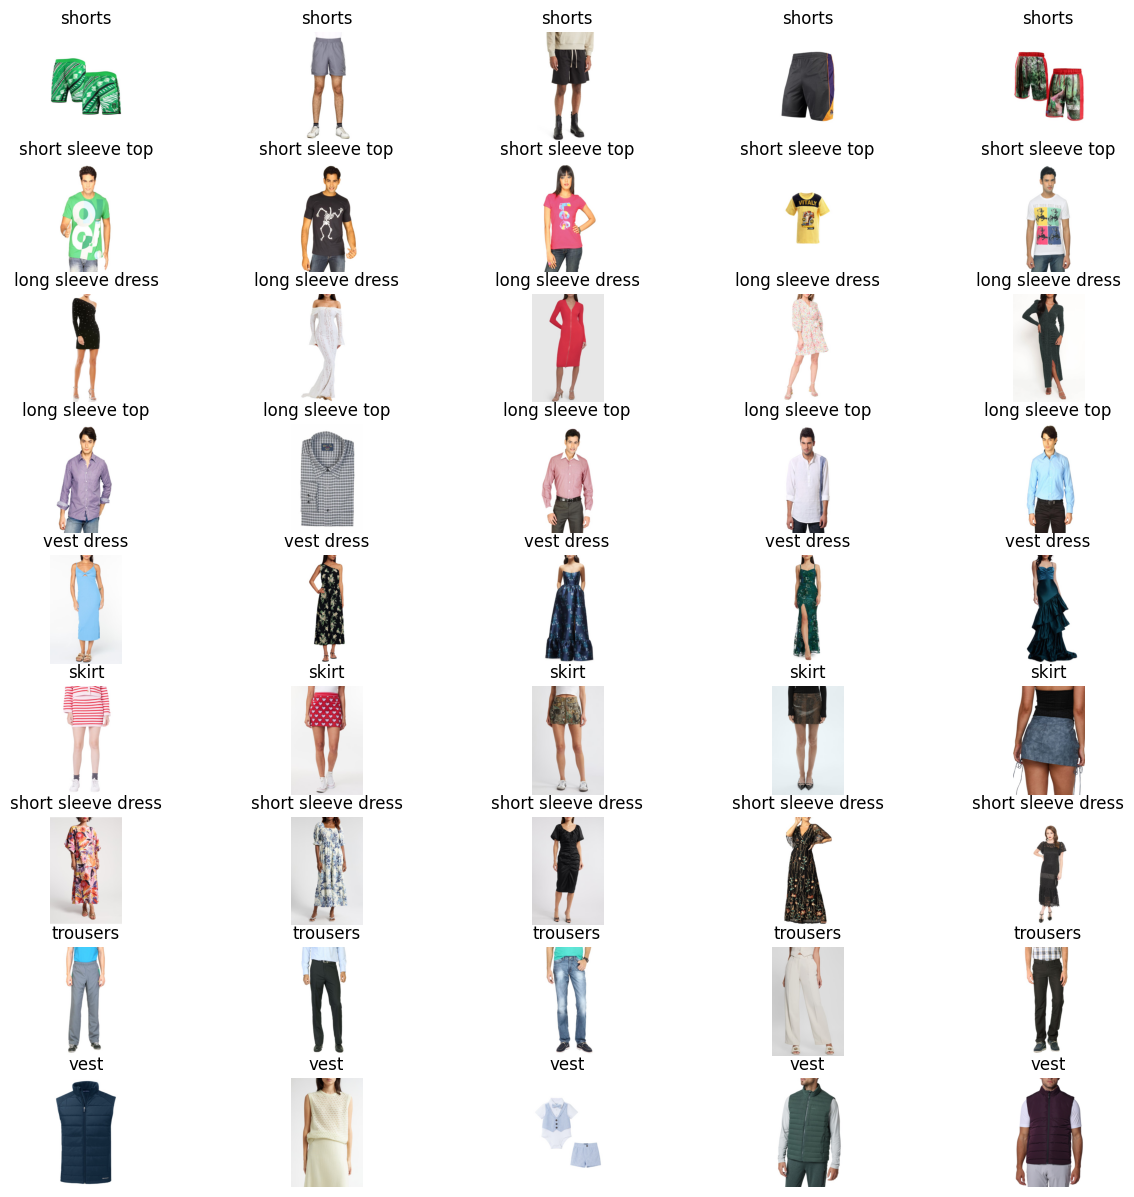

In [ ]:
fig, axs = plt.subplots(len(os.listdir("dataset/images/")), 5, figsize=(15, 15))
for i, category in enumerate(os.listdir("dataset/images/")):
  files = os.listdir("dataset/images/" + category)
  for j in range(5):
    img = plt.imread("dataset/images/" + category + "/" + files[np.random.randint(0, len(files))])
    axs[i, j].imshow(img)
    axs[i, j].set_title(category)
    axs[i, j].axis("off")
plt.show()

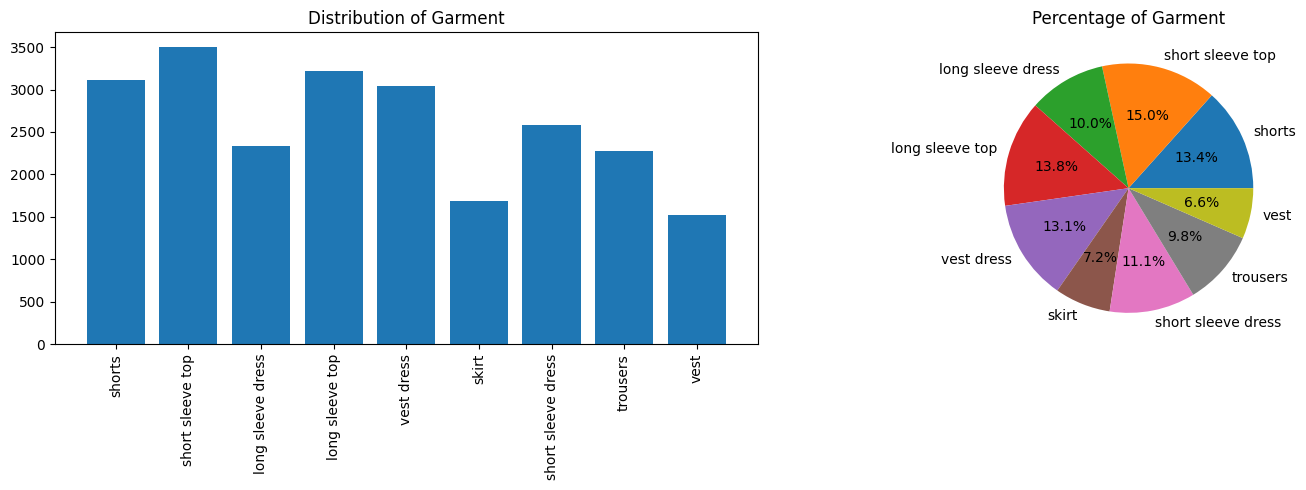

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

category_counts = {}
for category in os.listdir("dataset/images/"):
  category_counts[category] = len(os.listdir("dataset/images/" + category))

axs[0].bar(category_counts.keys(), category_counts.values())
axs[0].set_title("Distribution of Garment")
axs[0].set_xticks(range(len(category_counts.keys())))
axs[0].set_xticklabels(category_counts.keys(), rotation=90)

axs[1].pie(category_counts.values(), labels=category_counts.keys(), autopct="%1.1f%%")
axs[1].set_title("Percentage of Garment")

plt.tight_layout()
plt.show()

In [ ]:
def print_image_resolution(directory):
  unique_sizes = set()
  total_images = 0

  for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    image_files = os.listdir(subdir_path)
    num_images = len(image_files)
    print(f"{subdir}: {num_images}")
    total_images += num_images

    for img_file in image_files:
      img_path = os.path.join(subdir_path, img_file)
      with Image.open(img_path) as img:
        unique_sizes.add(img.size)

    for size in unique_sizes:
      print(f"- {size}")
    print("---------------")

  print(f"\nTotal: {total_images}")

print_image_resolution("dataset/images/")

shorts: 3111
- (480, 736)
---------------
short sleeve top: 3500
- (480, 736)
---------------
long sleeve dress: 2334
- (480, 736)
---------------
long sleeve top: 3215
- (480, 736)
---------------
vest dress: 3038
- (480, 736)
---------------
skirt: 1686
- (480, 736)
---------------
short sleeve dress: 2586
- (480, 736)
---------------
trousers: 2270
- (480, 736)
---------------
vest: 1526
- (480, 736)
---------------

Total: 23266


### Data Preprocessing

#### Split Dataset

In [ ]:
dataset_path = "dataset/images/"

file_name = []
labels = []
full_path = []

for path, subdirs, files_image in os.walk(dataset_path):
  for name in files_image:
    file_name.append(name)
    labels.append(path.split("/")[-1])
    full_path.append(os.path.join(path, name))

df = pd.DataFrame({"path": full_path, "file_name": file_name, "label": labels})
df.groupby(["label"]).size()

,0
label,
long sleeve dress,2334
long sleeve top,3215
short sleeve dress,2586
short sleeve top,3500
shorts,3111
skirt,1686
trousers,2270
vest,1526
vest dress,3038


In [ ]:
X = df["path"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
df_tr = pd.DataFrame({"path": X_train, "label": y_train, "set": "train"})
df_te = pd.DataFrame({"path": X_test, "label": y_test, "set": "test"})
df_va = pd.DataFrame({"path": X_val, "label": y_val, "set": "validation"})

df_all = pd.concat([df_tr, df_te, df_va], ignore_index=True)
df_all.groupby(["label", "set"]).size()

label               set       
long sleeve dress   test           248
                    train         1845
                    validation     241
long sleeve top     test           305
                    train         2605
                    validation     305
short sleeve dress  test           269
                    train         2074
                    validation     243
short sleeve top    test           371
                    train         2751
                    validation     378
shorts              test           293
                    train         2515
                    validation     303
skirt               test           164
                    train         1360
                    validation     162
trousers            test           223
                    train         1812
                    validation     235
vest                test           148
                    train         1211
                    validation     167
vest dress          test           306
                    train         2439
                    validation     293
dtype: int64

In [ ]:
df_all.sample(5)

,path,label,set
23160,dataset/images/long sleeve dress/long_sleeve_d...,long sleeve dress,validation
5679,dataset/images/short sleeve top/short_sleeve_t...,short sleeve top,train
7167,dataset/images/shorts/shorts_2296.jpg,shorts,train
6931,dataset/images/long sleeve top/long_sleeve_top...,long sleeve top,train
16421,dataset/images/vest/vest_643.jpg,vest,train


In [ ]:
for _, row in df_all.iterrows():
  source_path = row["path"]
  dest_dir = os.path.join("dataset", "final_dataset", row["set"], row["label"])
  os.makedirs(dest_dir, exist_ok=True)

  filename = os.path.basename(source_path)
  dest_path = os.path.join(dest_dir, filename)

  try:
    shutil.copyfile(source_path, dest_path)
  except Exception as e:
    print(f"Error copying {source_path} to {dest_path}: {e}")

#### Data Augmentation

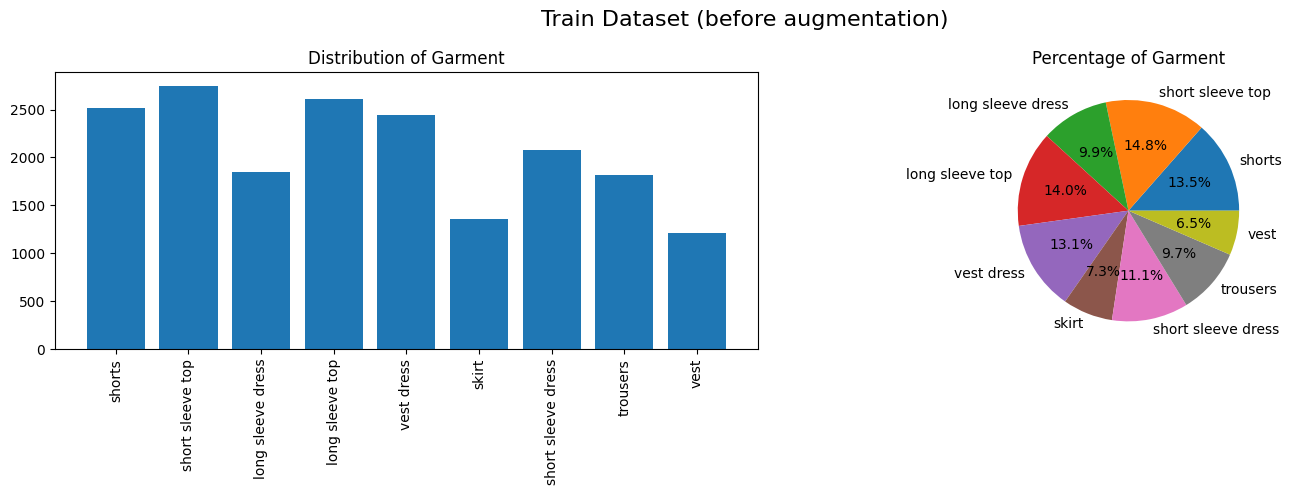

In [ ]:
train_dir = "dataset/final_dataset/train/"

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

category_counts = {}
for category in os.listdir(train_dir):
  category_counts[category] = len(os.listdir(train_dir + category))

plt.suptitle("Train Dataset (before augmentation)", fontsize=16)

axs[0].bar(category_counts.keys(), category_counts.values())
axs[0].set_title("Distribution of Garment")
axs[0].set_xticks(range(len(category_counts.keys())))
axs[0].set_xticklabels(category_counts.keys(), rotation=90)

axs[1].pie(category_counts.values(), labels=category_counts.keys(), autopct="%1.1f%%")
axs[1].set_title("Percentage of Garment")

plt.tight_layout()
plt.show()

In [ ]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(5, 20)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(5, 20)
    return rotate(img, -sudut)

def sheared(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

In [ ]:
transformation = {
    "anticlockwise_rotation": anticlockwise_rotation,
    "clockwise_rotation": clockwise_rotation,
    "sheared": sheared,
}

category_to_augment = ['skirt', 'vest','long sleeve dress',
                       'short sleeve dress', 'trousers']

images_path = "dataset/final_dataset/train/"
augmented_path = "dataset/augmented"
os.makedirs(augmented_path, exist_ok=True)

for category in category_to_augment:
  os.makedirs(augmented_path + "/" + category, exist_ok=True)

images_to_generate = {
    "skirt": 1000,
    "vest": 1000,
    "trousers": 500,
    "short sleeve dress": 300,
    "long sleeve dress": 500
}
i = 1

for category in category_to_augment:
  print(f"Augmenting category: {category}")
  images = []

  for im in os.listdir(images_path + category):
    images.append(images_path + category + "/" + im)

  while i <= images_to_generate[category]:
    image = random.choice(images)
    original_image = io.imread(image)
    transformed_image = None
    n = 0
    transformation_count = random.randint(1, len(transformation))

    while n < transformation_count:
      key = random.choice(list(transformation))
      transformed_image = transformation[key](original_image)
      n += 1

    new_file_path = "%s/augmented_image_%s.jpg" % (augmented_path + "/" + category, i)
    transformed_image = img_as_ubyte(transformed_image)
    cv2.imwrite(new_file_path, transformed_image)

    i += 1
  i = 1
  print(f"Augmented category: {category} done")

Augmenting category: skirt
Augmented category: skirt done
Augmenting category: vest
Augmented category: vest done
Augmenting category: long sleeve dress
Augmented category: long sleeve dress done
Augmenting category: short sleeve dress
Augmented category: short sleeve dress done
Augmenting category: trousers
Augmented category: trousers done


In [ ]:
# # delete final folder
# shutil.rmtree("dataset/final_dataset")

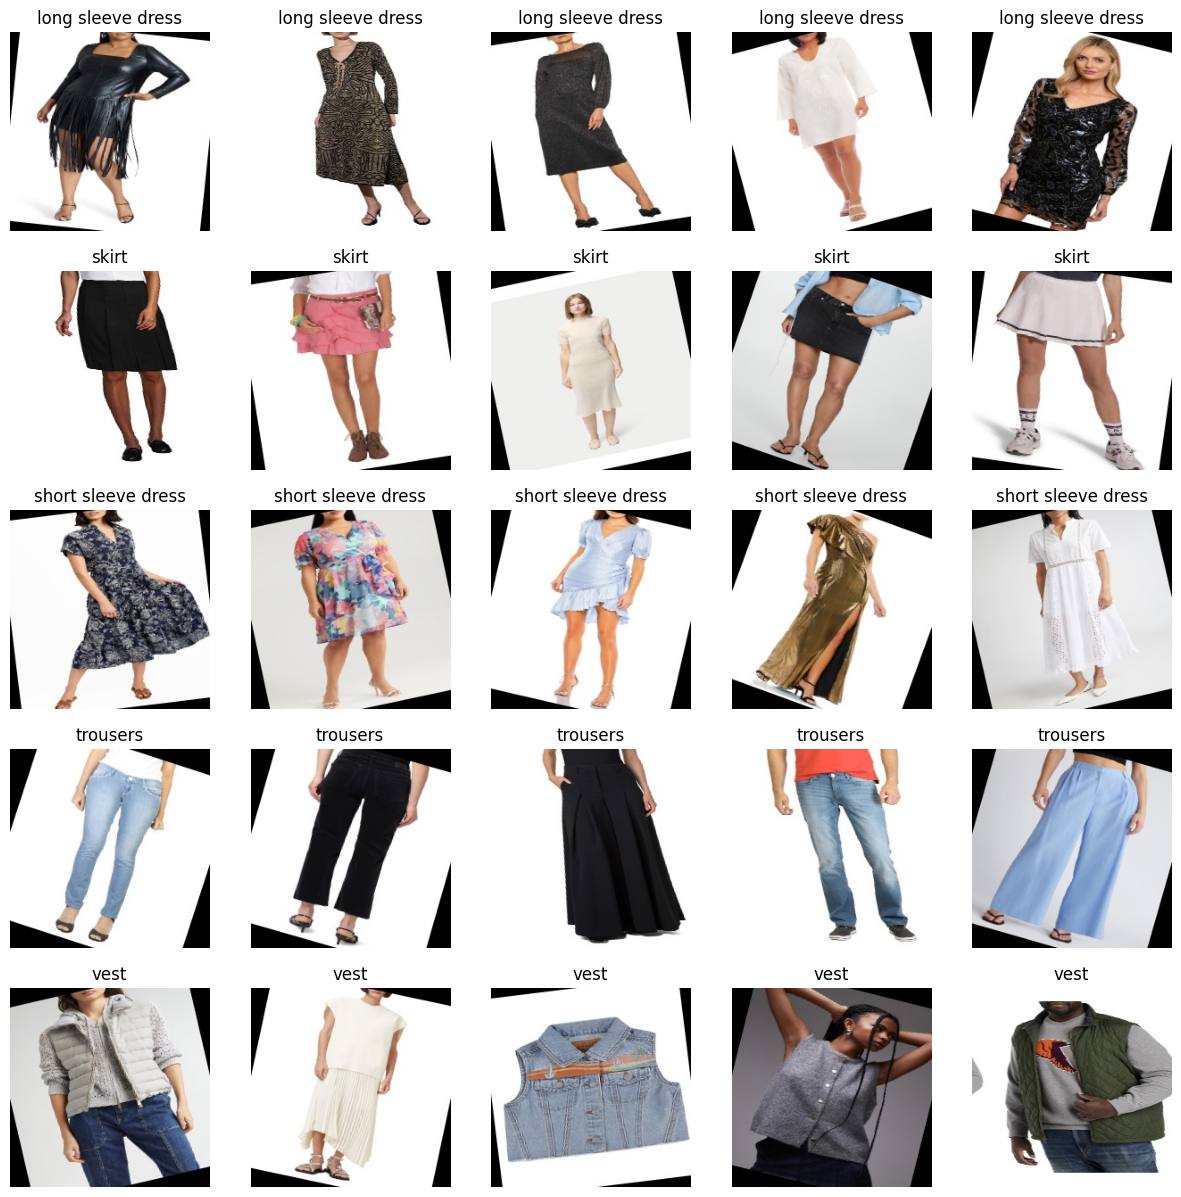

In [ ]:
fig, axs = plt.subplots(len(os.listdir("dataset/augmented/")), 5, figsize=(15, 15))
for i, category in enumerate(os.listdir("dataset/augmented/")):
  files = os.listdir("dataset/augmented/" + category)
  for j in range(5):
    img = plt.imread("dataset/augmented/" + category + "/" + files[np.random.randint(0, len(files))])
    axs[i, j].imshow(img)
    axs[i, j].set_title(category)
    axs[i, j].axis("off")
plt.show()

In [ ]:
final_path = "dataset/final_dataset/train_with_augmentation/"
os.makedirs(final_path, exist_ok=True)

for category in category_name:
  os.makedirs(final_path + category, exist_ok=True)
  for im in os.listdir(images_path + category):
    shutil.copyfile(images_path + category + "/" + im, final_path + category + "/" + im)
  print(f"{category} done")

for category in category_to_augment:
  os.makedirs(final_path + category, exist_ok=True)
  for im in os.listdir(augmented_path + "/" + category):
    shutil.copyfile(augmented_path + "/" + category + "/" + im, final_path + category + "/" + im)
  print(f"{category} (augmented) done")

shutil.rmtree("dataset/final_dataset/train")
print("remove train folder")

print("All done")

short sleeve top done
long sleeve top done
trousers done
shorts done
skirt done
vest done
vest dress done
short sleeve dress done
long sleeve dress done
skirt (augmented) done
vest (augmented) done
long sleeve dress (augmented) done
short sleeve dress (augmented) done
trousers (augmented) done
remove train folder
All done


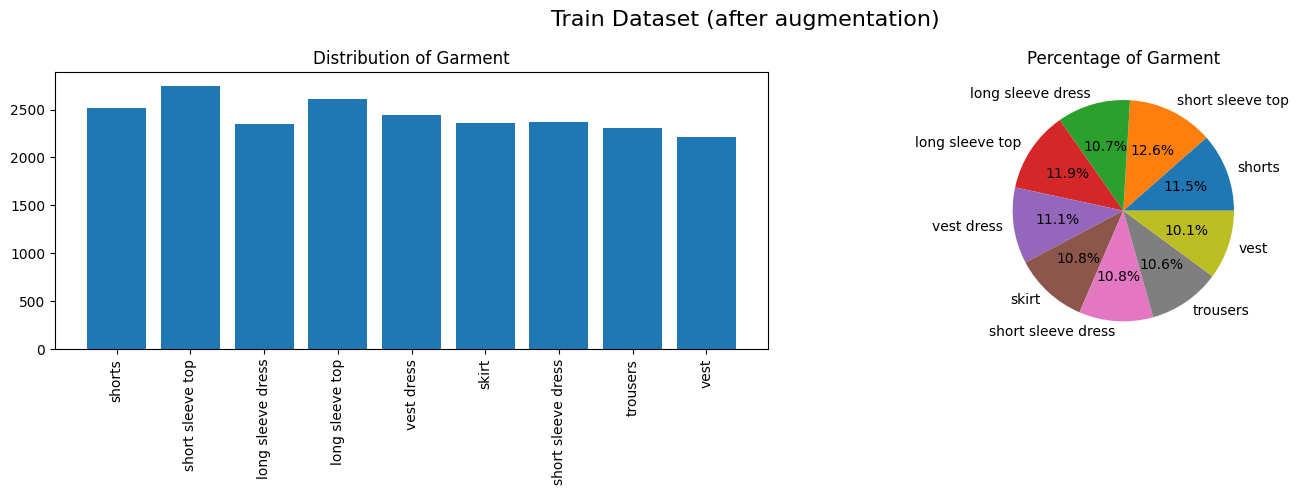

In [ ]:
train_with_augmentation_dir = "dataset/final_dataset/train_with_augmentation/"

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

category_counts = {}
for category in os.listdir(train_with_augmentation_dir):
  category_counts[category] = len(os.listdir(train_with_augmentation_dir + category))

plt.suptitle("Train Dataset (after augmentation)", fontsize=16)

axs[0].bar(category_counts.keys(), category_counts.values())
axs[0].set_title("Distribution of Garment")
axs[0].set_xticks(range(len(category_counts.keys())))
axs[0].set_xticklabels(category_counts.keys(), rotation=90)

axs[1].pie(category_counts.values(), labels=category_counts.keys(), autopct="%1.1f%%")
axs[1].set_title("Percentage of Garment")

plt.tight_layout()
plt.show()

In [ ]:
TRAIN_DIR = "dataset/final_dataset/train_with_augmentation/"
VAL_DIR = "dataset/final_dataset/validation/"
TEST_DIR = "dataset/final_dataset/test/"

train_datagen = ImageDataGenerator(rescale=1 / 255.,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1 / 255.)

test_datagen = ImageDataGenerator(rescale=1 / 255.)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                       batch_size=32,
                                                       target_size=(150,150),
                                                       color_mode="grayscale",
                                                       class_mode='categorical',
                                                       shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 21912 images belonging to 9 classes.
Found 2327 images belonging to 9 classes.
Found 2327 images belonging to 9 classes.


## Modelling

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("accuracy") > 0.95) and (logs.get("val_accuracy") > 0.95):
      print("\nReached 95% accuracy so cancelling")
      self.model.stop_training = True

callbacks = MyCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(150, 150, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(len(os.listdir(TRAIN_DIR)), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,242,633 (42.89 MB)

 Trainable params: 11,242,633 (42.89 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=685,
                    validation_data=validation_generator,
                    validation_steps=729,
                    callbacks=[callbacks, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3710 - loss: 1.7291

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


685/685 ━━━━━━━━━━━━━━━━━━━━ 79s 106ms/step - accuracy: 0.3712 - loss: 1.7285 - val_accuracy: 0.7443 - val_loss: 0.6906
Epoch 2/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 67s 98ms/step - accuracy: 0.6622 - loss: 0.8652 - val_accuracy: 0.7722 - val_loss: 0.5882
Epoch 3/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 79s 94ms/step - accuracy: 0.7239 - loss: 0.7244 - val_accuracy: 0.8165 - val_loss: 0.5104
Epoch 4/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 87s 102ms/step - accuracy: 0.7602 - loss: 0.6191 - val_accuracy: 0.8234 - val_loss: 0.4742
Epoch 5/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 67s 98ms/step - accuracy: 0.7935 - loss: 0.5440 - val_accuracy: 0.8419 - val_loss: 0.4517
Epoch 6/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 71s 103ms/step - accuracy: 0.8077 - loss: 0.5112 - val_accuracy: 0.8543 - val_loss: 0.4174
Epoch 7/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 65s 94ms/step - accuracy: 0.8331 - loss: 0.4562 - val_accuracy: 0.8582 - val_loss: 0.4183
Epoch 8/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 65s 96ms/step - accuracy: 0.8429 - loss: 0.4206 - val_accu

## Evaluasi dan Visualisasi

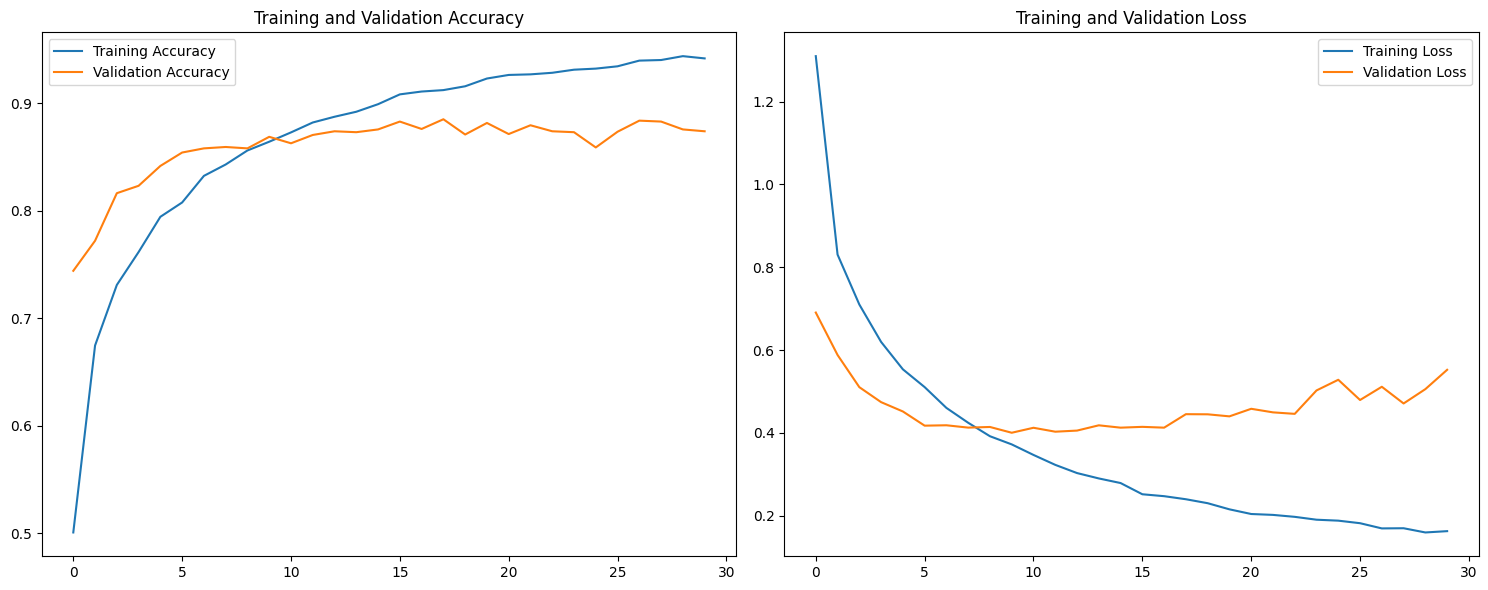

In [ ]:
acc_model = history.history["accuracy"]
val_acc_model = history.history["val_accuracy"]
loss_model= history.history["loss"]
val_loss_model = history.history["val_loss"]

epochs = range(len(acc_model))

fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(epochs, acc_model, label="Training Accuracy")
axs[0].plot(epochs, val_acc_model, label="Validation Accuracy")
axs[0].set_title("Training and Validation Accuracy")
axs[0].legend()

axs[1].plot(epochs, loss_model, label="Training Loss")
axs[1].plot(epochs, val_loss_model, label="Validation Loss")
axs[1].set_title("Training and Validation Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
                    precision    recall  f1-score   support

 long sleeve dress       0.75      0.78      0.76       248
   long sleeve top       0.94      0.96      0.95       305
short sleeve dress       0.76      0.74      0.75       269
  short sleeve top       0.97      0.95      0.96       371
            shorts       0.92      0.95      0.94       293
             skirt       0.81      0.76      0.79       164
          trousers       0.94      0.90      0.92       223
              vest       0.90      0.87      0.88       148
        vest dress       0.80      0.83      0.81       306

          accuracy                           0.87      2327
         macro avg       0.86      0.86      0.86      2327
      weighted avg       0.87      0.87      0.87      2327



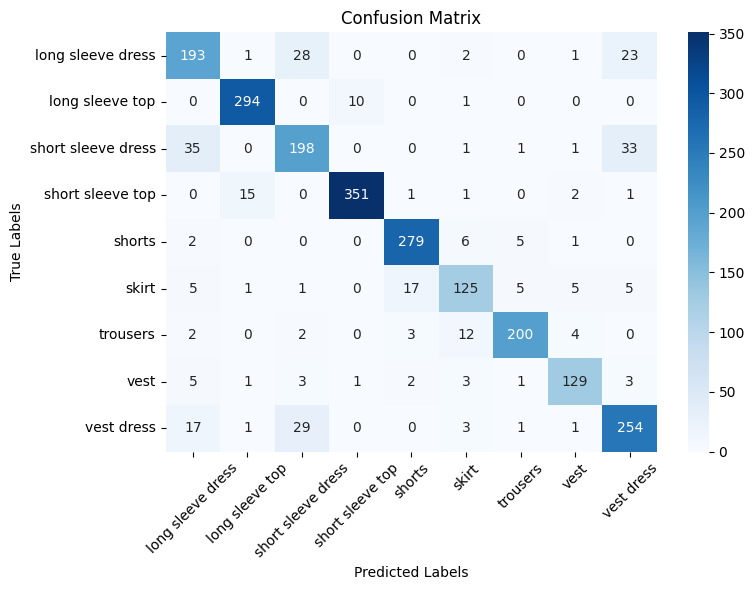

In [ ]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_name = list(test_generator.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_name)
print(report)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_name, yticklabels=class_name)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Konversi Model

### Saved model to SavedModel format

In [ ]:
save_path_model = "saved_model/"
tf.saved_model.save(model, save_path_model)

### Converted model to Tensorflow.js

In [ ]:
!tensorflowjs_converter \
    --input_format tf_saved_model \
    /content/saved_model/ \
    /content/tfjs_model

2025-05-25 12:45:58.712390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748177158.748347   11997 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748177158.762108   11997 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-25 12:46:11.552118: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748177171.552350   11997 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

### Converted model to Tensorflow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/saved_model/")
tflite_model = converter.convert()

with tf.io.gfile.GFile("model.tflite", "wb") as f:
  f.write(tflite_model)

## Inference

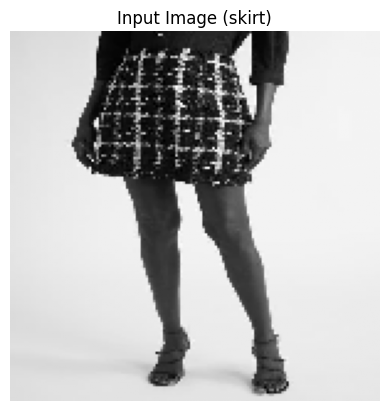

Prediction result:  [[1.9701892e-08 5.9427796e-20 4.0572361e-11 3.2174367e-16 2.9562440e-05
  9.9986899e-01 1.0143746e-04 3.7579256e-10 1.1269610e-15]]
Prediction class:  5
Prediction class name:  skirt


In [ ]:
model_path = "/content/saved_model/"
loaded_model = tf.saved_model.load(model_path)
infer = loaded_model.signatures["serving_default"]

img_path = "/content/dataset/final_dataset/test/skirt/skirt_1233.jpg"

img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=(150, 150),
    color_mode='grayscale'
)

plt.imshow(img, cmap='gray')
plt.title("Input Image (skirt)")
plt.axis('off')
plt.show()

img_array = image.img_to_array(img)
img_array /= 255.0
img_array = np.expand_dims(img_array, axis=0)

img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

y_pred = infer(inputs=img_tensor)

prediction = y_pred["output_0"].numpy()
print("Prediction result: ", prediction)
print("Prediction class: ", np.argmax(prediction))
print("Prediction class name: ", class_name[np.argmax(prediction)])